# ConvNet Implementation using PyTorch

- Application of convolutional layers
- Filter kernels
- Pooling layers (reduction of image)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


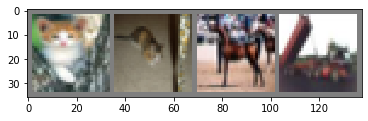

In [4]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [12]:
# implement conv net
# use CNN architecture to do this
# use a cnntest.py to figure out the sizes
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        # 3 color channels -> input channel size
        # 6 output channel size
        # 5 kernel size
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 2 by 2 kernel size so stride is 2
        self.pool = nn.MaxPool2d(2, 2)
        # second conv layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        # fully connected layer
        # It is very important to get the correct sizes
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # first conv and pool layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten
        x = x.view(-1, 16*5*5) # this will flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # no activation function at the end
        # also no softmax because its included in the loss
        x = self.fc3(x)
        return x

In [13]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss() # softmax included here
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad() # don't forget to zero gradients
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

# avoid backward propagation when calculating accuracies
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Epoch [1/5], Step [2000/12500], Loss: 2.2978
Epoch [1/5], Step [4000/12500], Loss: 2.2859
Epoch [1/5], Step [6000/12500], Loss: 2.2195
Epoch [1/5], Step [8000/12500], Loss: 2.3989
Epoch [1/5], Step [10000/12500], Loss: 2.4006
Epoch [1/5], Step [12000/12500], Loss: 2.7046
Epoch [2/5], Step [2000/12500], Loss: 2.2101
Epoch [2/5], Step [4000/12500], Loss: 1.9512
Epoch [2/5], Step [6000/12500], Loss: 1.9271
Epoch [2/5], Step [8000/12500], Loss: 1.8251
Epoch [2/5], Step [10000/12500], Loss: 1.1429
Epoch [2/5], Step [12000/12500], Loss: 1.3731
Epoch [3/5], Step [2000/12500], Loss: 1.8929
Epoch [3/5], Step [4000/12500], Loss: 1.6618
Epoch [3/5], Step [6000/12500], Loss: 1.6808
Epoch [3/5], Step [8000/12500], Loss: 2.2127
Epoch [3/5], Step [10000/12500], Loss: 1.3316
Epoch [3/5], Step [12000/12500], Loss: 1.8877
Epoch [4/5], Step [2000/12500], Loss: 1.2559
Epoch [4/5], Step [4000/12500], Loss: 2.4858
Epoch [4/5], Step [6000/12500], Loss: 1.9484
Epoch [4/5], Step [8000/12500], Loss: 1.6762
Epoc